<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Data_analysis_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis and Results

In [2]:
!pip install tensorflow_addons

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print("Tensorflow version: ",tf.__version__)

Tensorflow version:  2.8.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Testing Sets and Models

In [106]:
loc = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/test"
data_dir = pathlib.Path(loc)

batch_size = 32
img_height = 224
img_width = 224

#Testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1297 files belonging to 10 classes.


In [6]:
sample_class = 'African elephant'
class_idx = np.where(np.array(test_ds.class_names) == sample_class)[0][0]

In [108]:
# Used to grab a clean batch of data from the testing set
class_names = np.where(test_ds.class_names == "African elephant")
img_batch,img_labels = next(iter(test_ds))

In [104]:
batch_arr = img_batch.numpy()
label_arr = img_labels.numpy()

sample_bool = np.argmax(label_arr,axis=1) == class_idx
elephant_img = batch_arr[sample_bool,:,:,:][0].astype("uint8")

stripe_width = 5
stripes_arr = np.array([False for i in range(224)])
for i in range(0,224,stripe_width+10):
  stripes_arr[i:i+stripe_width] = True

striped_elephant = elephant_img.copy()
striped_elephant[stripes_arr,:,:] = 0
striped_elephant[:,stripes_arr,:] = 0

blurred_elephant = tfa.image.gaussian_filter2d(elephant_img,filter_shape=(10,10),sigma=5.0).numpy()

(-0.5, 223.5, 223.5, -0.5)

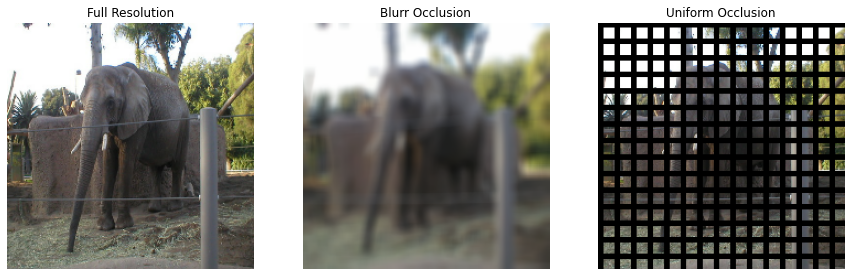

In [105]:
fig, ax = plt.subplots(1,3,figsize=(15,15))


ax[0].imshow(elephant_img)
ax[0].set_title("Full Resolution")
ax[0].axis("off")
ax[1].imshow(blurred_elephant)
ax[1].set_title("Blurr Occlusion")
ax[1].axis("off")
ax[2].imshow(striped_elephant)
ax[2].set_title("Uniform Occlusion")
ax[2].axis("off")

In [6]:
def img_transforms(data,label): #The vanilla testing set
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

def blurr_img_transforms(data,label): #The blurred testing set
    data = tfa.image.gaussian_filter2d(data,filter_shape=(10,10),sigma=5.0)
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE
test_ds_vanilla = test_ds.map(img_transforms)
test_ds_blurred = test_ds.map(blurr_img_transforms)

CASHE_Test_vanilla = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/CASHE_Test_10_1500"
test_ds_vanilla = test_ds_vanilla.cache(CASHE_Test_vanilla).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_blurred = "/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Imagenet-10-1500-splits/CASHE_Test_Dist_Blur_10_1500"
test_ds_blurred = test_ds_blurred.cache(CASHE_Test_blurred).prefetch(buffer_size=AUTOTUNE)

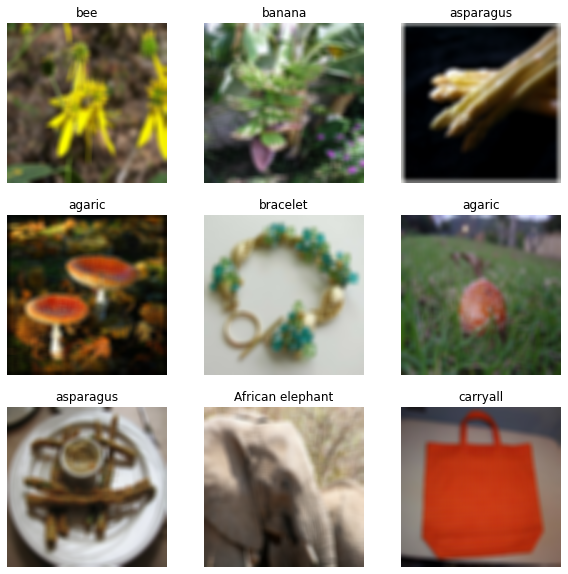

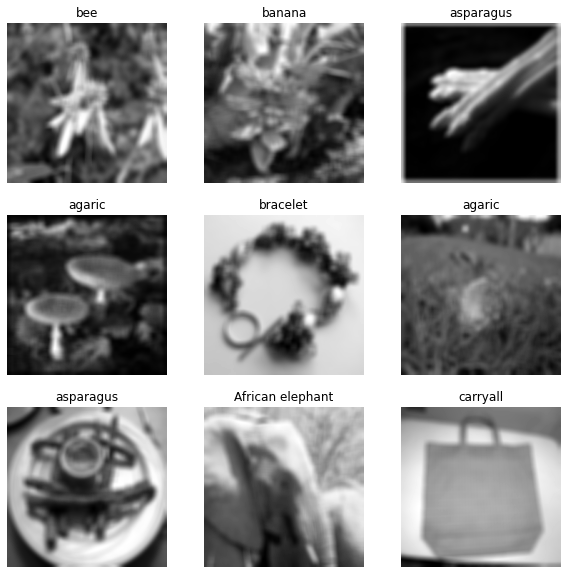

In [ ]:
#Need to run to test that the correct image transformations were applied

class_names = test_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in test_ds_blurred.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds_blurred.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in test_ds_vanilla:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

In [ ]:
dual_stream_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Early_Testing_Models/Dualstream_with_CNN_1000_Samples_10Classes")
single_model = tf.keras.models.load_model("/content/drive/MyDrive/School/MIT Spring2022/9.60/Vision Project/Vision Dataset/Models/Early_Testing_Models/FullRes_with_CNN_1000_Samples_10Classes")

### Testing the Vanilla Testing Set

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_vanilla)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_vanilla)

41/41 [==============================] - 10s 214ms/step - loss: 1.0598 - accuracy: 0.7032


In [ ]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_vanilla)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_vanilla)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_vanilla])
true_outputs = np.argmax(true_outputs,axis=1)

In [ ]:
print(classification_report(true_outputs,dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       140
           1       0.94      0.86      0.90       127
           2       0.75      0.82      0.78       135
           3       0.68      0.85      0.76       125
           4       0.67      0.82      0.74       125
           5       0.75      0.69      0.72       128
           6       0.89      0.81      0.85       139
           7       0.83      0.55      0.66       127
           8       0.85      0.79      0.82       127
           9       0.67      0.73      0.70       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297



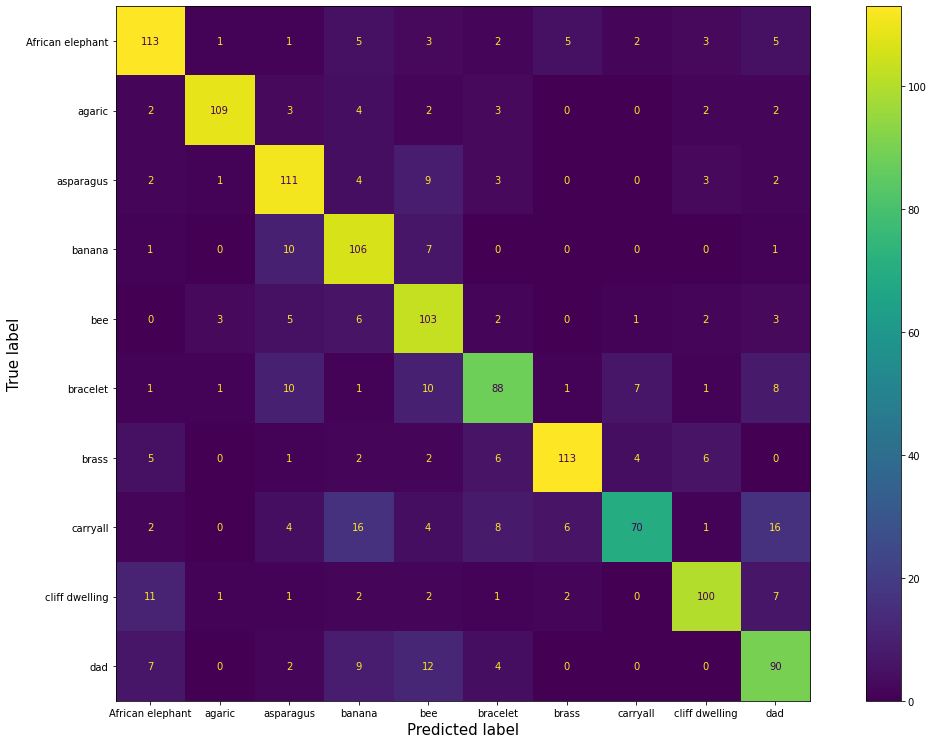

In [ ]:
#Generate Confusion Matrix for Dual-stream model
cm = confusion_matrix(true_outputs,dual_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

In [ ]:
print(classification_report(true_outputs,single_pred_outputs))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       140
           1       0.97      0.91      0.93       127
           2       0.63      0.79      0.70       135
           3       0.71      0.82      0.76       125
           4       0.75      0.70      0.73       125
           5       0.67      0.78      0.72       128
           6       0.77      0.84      0.80       139
           7       0.78      0.57      0.66       127
           8       0.79      0.94      0.86       127
           9       0.82      0.60      0.69       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297



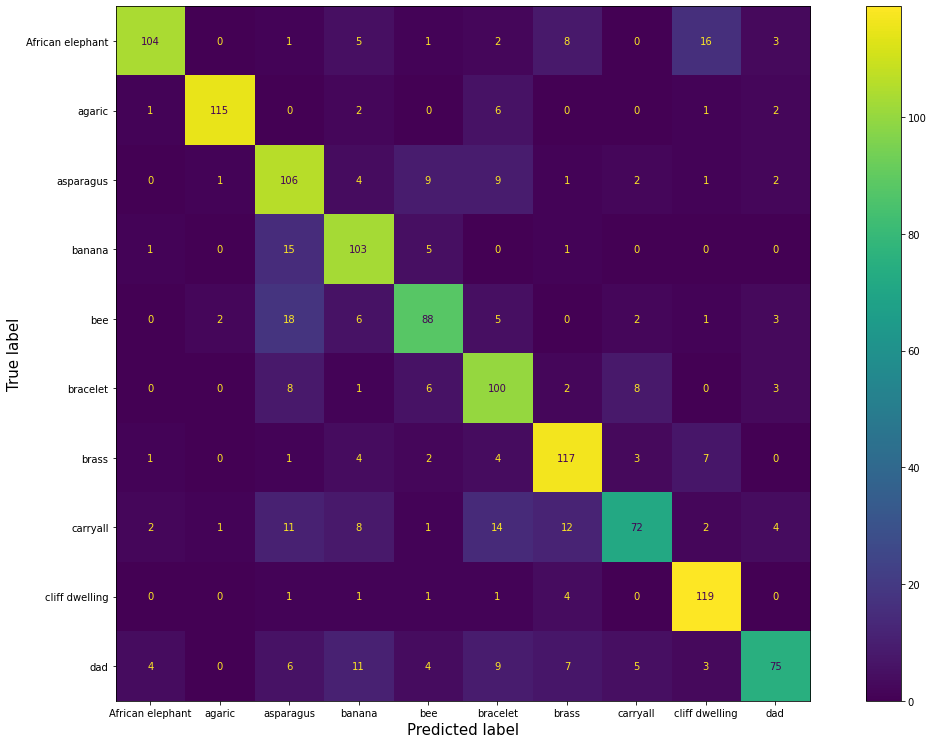

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet
cm = confusion_matrix(true_outputs,single_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

### Testing the Blurred condition

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_blurred)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_blurred)

41/41 [==============================] - 9s 214ms/step - loss: 1.6913 - accuracy: 0.4857


In [ ]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_blurred)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_blurred)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_blurred])
true_outputs = np.argmax(true_outputs,axis=1)

In [ ]:
print(classification_report(true_outputs,dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       140
           1       0.96      0.71      0.81       127
           2       0.39      0.84      0.53       135
           3       0.45      0.38      0.41       125
           4       0.46      0.71      0.56       125
           5       0.56      0.50      0.53       128
           6       0.88      0.38      0.53       139
           7       0.61      0.38      0.47       127
           8       0.65      0.33      0.44       127
           9       0.46      0.63      0.53       124

    accuracy                           0.54      1297
   macro avg       0.61      0.54      0.54      1297
weighted avg       0.61      0.54      0.54      1297



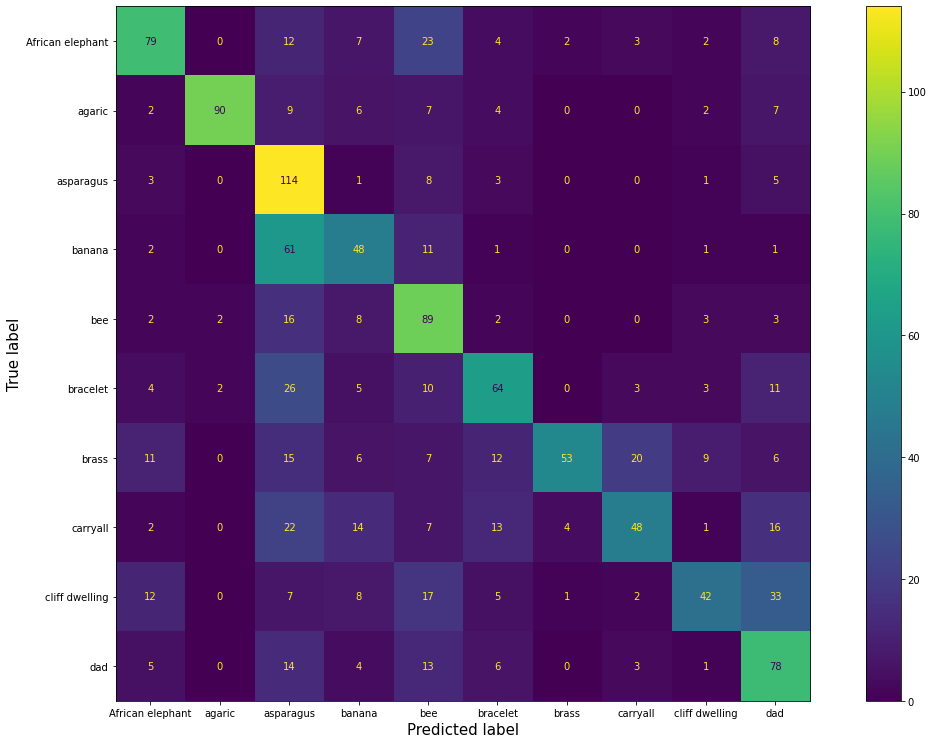

In [ ]:
#Generate Confusion Matrix for Dual-stream model
cm = confusion_matrix(true_outputs,dual_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)

In [ ]:
print(classification_report(true_outputs,single_pred_outputs))

              precision    recall  f1-score   support

           0       0.87      0.44      0.58       140
           1       0.97      0.77      0.86       127
           2       0.39      0.88      0.54       135
           3       0.66      0.60      0.63       125
           4       0.63      0.70      0.66       125
           5       0.51      0.70      0.59       128
           6       0.88      0.68      0.76       139
           7       0.85      0.31      0.46       127
           8       0.79      0.72      0.75       127
           9       0.59      0.60      0.60       124

    accuracy                           0.64      1297
   macro avg       0.71      0.64      0.64      1297
weighted avg       0.72      0.64      0.64      1297



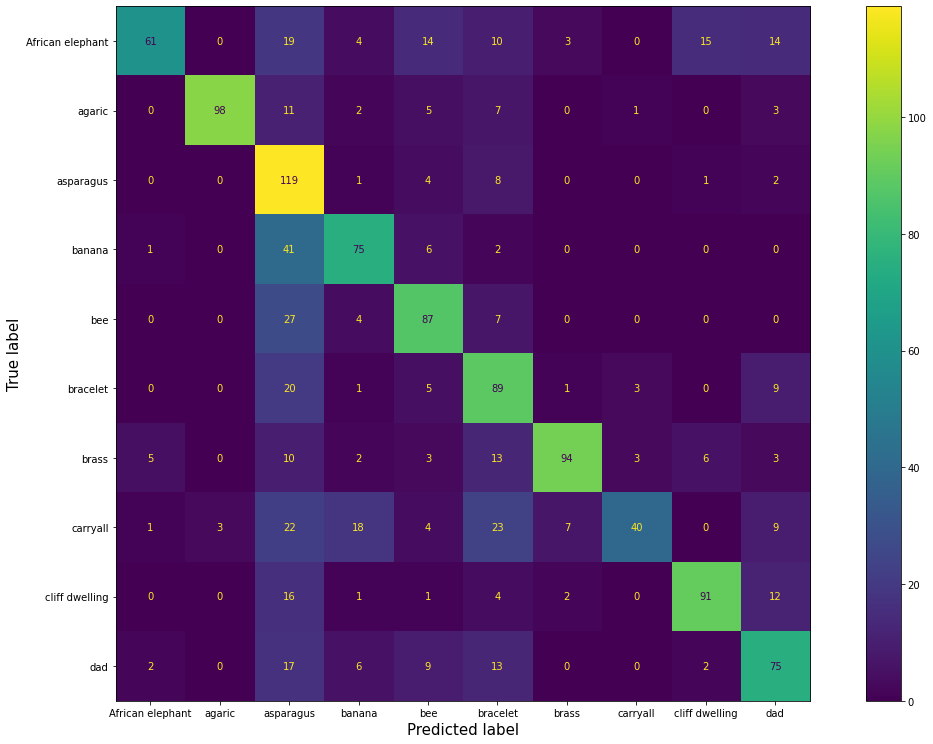

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet
cm = confusion_matrix(true_outputs,single_pred_outputs)
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
plt.tight_layout()

disp_cm.plot(ax=ax)